In [ ]:
import treelite
import os
import tl2cgen
import sklearn.datasets as datasets
import xgboost as xgb
import numpy as np
import subprocess
import random
import subprocess
import matplotlib.pyplot as plt

In [252]:

def FreeTayK(path: str):
    with open(path, 'r+') as f:
        data = f.readlines()
        f.seek(0, 0)
        f.write('#include "quantize.c"\n' + ''.join(data[2:]))
    
def create_c_array_string(array):
    array_string = "{\n"
    array_string += ",\n".join("{" + ", ".join(str(x) for x in row) + "}" for row in array)
    array_string += "\n}"
    return array_string

def count_decimals(number):
    str_num = str(number)
    if '.' not in str_num:
        return 0
    return len(str_num) - str_num.index('.') - 1

def beg_c_file_str(nr_datasets, nr_treedepths) :
    a = """
#include <time.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <windows.h>
#include "dll_paths.h"


typedef void (*PredictFunction)(union Entry*, int, float*);
int main() {
char times["""+str(nr_datasets*nr_treedepths*30)+"""] = "";
int k=0;
int nr_treedepths = """+str(nr_treedepths)+""";
    """
    return a

def mid_c_file_str(i, nr_results, resuses):
    a = """
//////////////////////////////////////////////

    for (int i = (0+(k*3))*nr_treedepths; i < (3 +(k*3))*nr_treedepths; i++) {
        HINSTANCE hDLL = LoadLibraryA(dll_paths[i]);
        if (hDLL == NULL) {
            return 1;
        }
        PredictFunction predict = (PredictFunction) GetProcAddress(hDLL, "predict");
        clock_t start = clock();
        for (int z = 0; z < """+str(nr_validation_reuses)+"""; z++) {
            for (int j = 0; j < sizeof(validation_instances"""+str(i)+""")/sizeof(validation_instances"""+str(i)+"""[0]); j++) {
                float result["""+str(nr_results)+"""]={0.0f};
                predict(validation_instances"""+str(i)+"""[i], 0, &result);
            }
        }
        FreeLibrary(hDLL);
        clock_t end = clock();
        double elapsed_time = ((double) (end - start)) / CLOCKS_PER_SEC;
        sprintf(times + strlen(times), "%6.3f\\n", elapsed_time);
    }
k++;

//////////////////////////////////////////////
"""
    return a

def end_c_file_str() :
    a = """
FILE *file = fopen("times.txt", "w");
if (file == NULL) {
    printf("Could not open file for writing.\\n");
    return 1;
}
fprintf(file, times);
fclose(file);
return 0;
}
    """
    return a

def compile_c_file(c_file_path):
    # gcc is the compiler, -o is used to specify the output file
    # 'output' is the name of the output file
    command = ['gcc', c_file_path, '-o', 'output']

    try:
        # Run the command
        subprocess.check_call(command)
        print("Compilation successful.")
    except subprocess.CalledProcessError:
        print("Compilation failed.")

def run_exe_file(exe_file_path):
    try:
        # Run the executable file
        subprocess.check_call(exe_file_path)
        print("Execution successful.")
    except subprocess.CalledProcessError:
        print("Execution failed.")


nr_instances_validation = 1000
toy_datasets = [datasets.load_iris, datasets.load_wine, datasets.load_breast_cancer]
tree_depths = [1, 5, 10, 15, 20, 30, 50]

header_file_str = r'const char *dll_paths[] = {'
c_file_str = beg_c_file_str(len(toy_datasets), len(tree_depths))
dll_file_paths = []
nr_results = []
validation_instances = []
validation_instances_str = r''
nr_validation_reuses = 300

for i, dataset in enumerate(toy_datasets):
    for depth in tree_depths:

        # Train models
        X, y = dataset(return_X_y=True)
        dtrain = xgb.DMatrix(X, label=y)
        params = {"max_depth": 1, "eta": 0.1, "objective": "multi:softprob", "eval_metric": "mlogloss", "num_class": 3}
        bst = xgb.train(params, dtrain, num_boost_round=20, evals=[(dtrain, 'train')])
        model = treelite.Model.from_xgboost(bst)

        path_no_param = "./Trees/model"+str(i)+"N"+str(depth)
        path_flint = "./Trees/model"+str(i)+"F"+str(depth)
        path_quantize = "./Trees/model"+str(i)+"Q"+str(depth)

        tl2cgen.generate_c_code(model, dirpath=path_no_param, params={})
        tl2cgen.generate_c_code(model, dirpath=path_flint, params={"flint" : 1})
        tl2cgen.generate_c_code(model, dirpath=path_quantize, params={"quantize": 1})

        # Generate DLLs
        path_no_param_dll = path_no_param + '/predict.dll'
        path_flint_dll = path_flint + '/predict.dll'
        path_quantize_dll = path_quantize + '/predict.dll'

        dll_file_paths.append(path_no_param_dll)
        dll_file_paths.append(path_flint_dll)
        dll_file_paths.append(path_quantize_dll)

        FreeTayK(path_quantize + '/main.c')
        
        # Compile the generated C code into DLLs
        subprocess.run(['gcc', '-shared', '-o', path_no_param_dll, path_no_param + '/main.c']),
        subprocess.run(['gcc', '-shared', '-o', path_flint_dll, path_flint + '/main.c']),
        subprocess.run(['gcc', '-shared', '-o', path_quantize_dll, path_quantize + '/main.c'])

    # Generate random validation instances with decimal precision equal to the maximum decimal precision of the training data
    min_values_feature = []
    max_values_feature = []
    nr_decimals = np.zeros((X.shape[0], X.shape[1]))
    max_decimals = []

    nr_results = len(np.unique(y))

    for k in range(X.shape[0]):
        for j in range(X.shape[1]):
            nr_decimals[i][j] = count_decimals(X[k][j])

    for k in range(X.shape[1]):
        max_decimals.append(max(nr_decimals[:, k]))


    for k in range(X.shape[1]):
        min_values_feature.append(X[:, k].min())
        max_values_feature.append(X[:, k].max())

    validation_instances = np.zeros((nr_instances_validation, X.shape[1]))
    for j in range(nr_instances_validation):
        for k in range(X.shape[1]):
            validation_instances[j][k] = round(random.uniform(min_values_feature[k], max_values_feature[k]), int(max_decimals[k]))
    


    c_file_str += mid_c_file_str(i, nr_results, nr_validation_reuses)
    validation_instances_str += 'float validation_instances'+str(i)+'[][' + str(X.shape[1]) + '] = ' + create_c_array_string(validation_instances) + ';\n'

header_file_str += ', '.join([f'"{path}"' for path in dll_file_paths]) + '};\n'

print (header_file_str)
header_file_str += validation_instances_str



with open('dll_paths.h', 'w') as f:
    f.write(header_file_str)


c_file_str += end_c_file_str()
with open('generated_speedTest.c', 'w') as f:
    f.write(c_file_str)



[0]	train-mlogloss:1.00183
[1]	train-mlogloss:0.91882
[2]	train-mlogloss:0.84626
[3]	train-mlogloss:0.78161
[4]	train-mlogloss:0.72429
[5]	train-mlogloss:0.67238
[6]	train-mlogloss:0.62590
[7]	train-mlogloss:0.58370
[8]	train-mlogloss:0.54542
[9]	train-mlogloss:0.51057
[10]	train-mlogloss:0.47876
[11]	train-mlogloss:0.44963
[12]	train-mlogloss:0.42290
[13]	train-mlogloss:0.39846
[14]	train-mlogloss:0.37577
[15]	train-mlogloss:0.35506
[16]	train-mlogloss:0.33578
[17]	train-mlogloss:0.31808
[18]	train-mlogloss:0.30168
[19]	train-mlogloss:0.28651
[18:29:20] C:\Users\Jesper\tl2cgen\src\compiler\ast\split.cc:30: Parallel compilation disabled; all member trees will be dumped to a single source file. This may increase compilation time and memory usage.
[18:29:20] C:\Users\Jesper\tl2cgen\src\compiler\ast\split.cc:30: Parallel compilation disabled; all member trees will be dumped to a single source file. This may increase compilation time and memory usage.
[18:29:20] C:\Users\Jesper\tl2cgen\src

c:\Users\Jesper\AppData\Local\Programs\Python\Python312\Lib\site-packages\treelite\model.py:179: FutureWarning: treelite.Model.from_xgboost() is deprecated. Use treelite.frontend.from_xgboost() instead.
  warnings.warn(


[0]	train-mlogloss:1.00183
[1]	train-mlogloss:0.91882
[2]	train-mlogloss:0.84626
[3]	train-mlogloss:0.78161
[4]	train-mlogloss:0.72429
[5]	train-mlogloss:0.67238
[6]	train-mlogloss:0.62590
[7]	train-mlogloss:0.58370
[8]	train-mlogloss:0.54542
[9]	train-mlogloss:0.51057
[10]	train-mlogloss:0.47876
[11]	train-mlogloss:0.44963
[12]	train-mlogloss:0.42290
[13]	train-mlogloss:0.39846
[14]	train-mlogloss:0.37577
[15]	train-mlogloss:0.35506
[16]	train-mlogloss:0.33578
[17]	train-mlogloss:0.31808
[18]	train-mlogloss:0.30168
[19]	train-mlogloss:0.28651
[18:29:20] C:\Users\Jesper\tl2cgen\src\compiler\ast\split.cc:30: Parallel compilation disabled; all member trees will be dumped to a single source file. This may increase compilation time and memory usage.
[18:29:20] C:\Users\Jesper\tl2cgen\src\compiler\ast\split.cc:30: Parallel compilation disabled; all member trees will be dumped to a single source file. This may increase compilation time and memory usage.
[18:29:20] C:\Users\Jesper\tl2cgen\src

In [253]:
compile_c_file('generated_speedTest.c')
run_exe_file('output')
with open('times.txt', 'r') as f:
    times_content = f.read()
times = np.fromstring(times_content, sep='\n')
times


Compilation successful.
Execution successful.


array([0.052, 0.051, 0.114, 0.06 , 0.052, 0.062, 0.056, 0.051, 0.062,
       0.052, 0.059, 0.061, 0.056, 0.057, 0.062, 0.054, 0.055, 0.062,
       0.052, 0.051, 0.061, 0.051, 0.052, 0.084, 0.056, 0.051, 0.086,
       0.052, 0.053, 0.088, 0.053, 0.057, 0.083, 0.05 , 0.051, 0.088,
       0.051, 0.052, 0.099, 0.052, 0.06 , 0.088, 0.05 , 0.049, 0.136,
       0.05 , 0.059, 0.136, 0.05 , 0.051, 0.138, 0.055, 0.05 , 0.137,
       0.052, 0.051, 0.133, 0.051, 0.051, 0.136, 0.054, 0.052, 0.139])

In [226]:
with open('times.txt', 'r') as f:
    times_content = f.read()
times = np.fromstring(times_content, sep='\n')
times

array([0.017, 0.016, 0.02 , 0.017, 0.017, 0.02 , 0.017, 0.017, 0.02 ,
       0.018, 0.02 , 0.02 , 0.018, 0.017, 0.022, 0.018, 0.017, 0.02 ,
       0.017, 0.016, 0.02 , 0.016, 0.017, 0.029, 0.017, 0.016, 0.029,
       0.017, 0.016, 0.028, 0.017, 0.018, 0.029, 0.018, 0.017, 0.03 ,
       0.023, 0.017, 0.027, 0.017, 0.016, 0.027, 0.018, 0.016, 0.045,
       0.017, 0.016, 0.046, 0.017, 0.017, 0.046, 0.017, 0.021, 0.049,
       0.016, 0.017, 0.044, 0.017, 0.016, 0.047, 0.017, 0.017, 0.045])

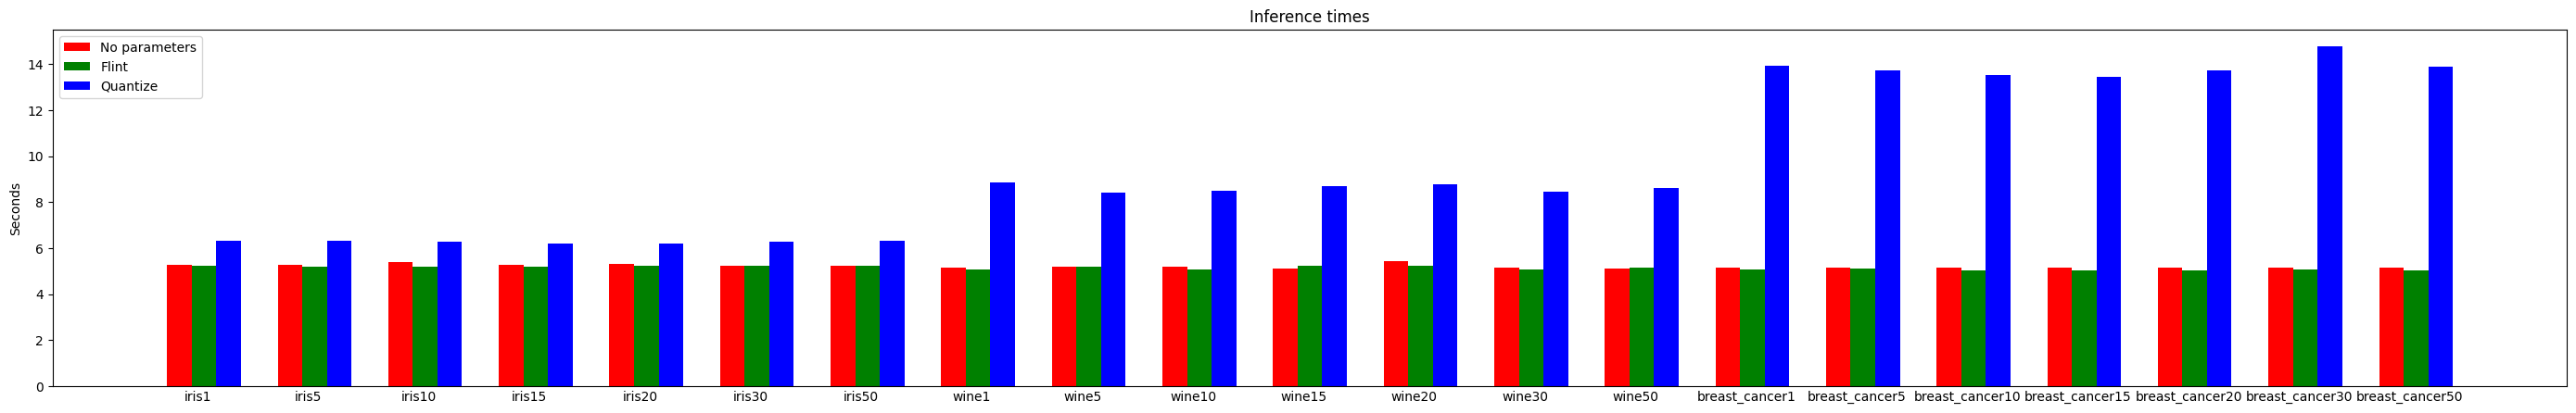

In [250]:
# Figure scaling so that 6 bar groups are 10 wide
plt.figure(figsize=((len(times)/3)*(10/6), 5))

x = np.arange(0, len(times), 3)

# Width of a bar 
width = 2

# Create the bar chart for each group with different colors
colors = ['red', 'green', 'blue']
labels = ['No parameters', 'Flint', 'Quantize']
for i in range(3):
    plt.bar(x + i*(width/3), times[i::3], color=colors[i], width=width/3, label=labels[i])

# Assuming 'names' is your array of group names
dataset_names = [func.__name__.replace('datasets.', '') for func in toy_datasets]
dataset_names = [f"{name}{depth}" for name in dataset_names for depth in tree_depths]

for i in range(len(dataset_names)):
    dataset_names[i] = dataset_names[i].replace('load_', '')

# Set the x-tick labels to the group names and remove the x-axis
plt.xticks(x-0.5 + width/2, dataset_names)
plt.tick_params(axis='x', length=0)

plt.ylabel('Seconds')
plt.title('Inference times')

# Display the legend
plt.legend()

plt.show()

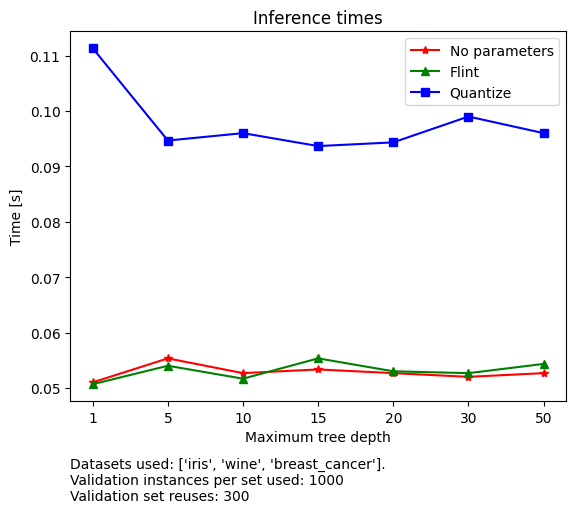

In [254]:
dataset_names = [func.__name__.replace('datasets.', '') for func in toy_datasets]
for i in range(len(dataset_names)):
    dataset_names[i] = dataset_names[i].replace('load_', '')


times_no_parameters = [np.mean(times[i*3::len(tree_depths)*3]) for i in range(len(tree_depths))]
times_flint = [np.mean(times[i*3+1::len(tree_depths)*3]) for i in range(len(tree_depths))]
times_quantize = [np.mean(times[i*3+2::len(tree_depths)*3]) for i in range(len(tree_depths))]

# Create the line plot for each group with different colors
plt.plot(range(len(tree_depths)), times_no_parameters, color='red', marker='*', label='No parameters')
plt.plot(range(len(tree_depths)), times_flint, color='green', marker='^', label='Flint')
plt.plot(range(len(tree_depths)), times_quantize, color='blue', marker='s', label='Quantize')

# Set the x-tick labels to the values in tree_depths
plt.xticks(range(len(tree_depths)), tree_depths)

plt.xlabel('Maximum tree depth')
plt.ylabel('Time [s]')
plt.title('Inference times')

plt.text(0, -0.15, 'Datasets used: '+str(dataset_names)+'.\nValidation instances per set used: '+str(nr_instances_validation)+'\nValidation set reuses: '+str(nr_validation_reuses), ha='left', va='top', transform=plt.gca().transAxes)

# Display the legend
plt.legend()

plt.show()